<a href="https://colab.research.google.com/github/bhavikaradadiya/Plant-Disease-Classification/blob/main/Notebook/Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='PlantVillage.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('/content/PlantVillage.zip')
f.keys()
!unzip 'PlantVillage.zip'

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/52c7d07b-561b-4380-801a-3824e65a5135___RS_HL 3797.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53168d1c-ac90-4039-9eff-7479475a6b74___RS_HL 6355.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5344b09f-bbbe-4a2c-9345-d93dd4e69eb4___RS_HL 4693.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5361ba4a-351e-466c-99c5-8845f35c00df___RS_HL 2890.JPG  
  inflating: PlantVillage/val/Soybean___healthy/537e5409-d824-4859-967f-3c502f13deec___RS_HL 5474.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538969da-545b-4bce-bc1d-0932898dc5e6___RS_HL 5230.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538ccfe2-1509-40d7-beae-ae7cf84e1e5d___RS_HL 3717.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5397bf6a-aeeb-4f1c-b554-bdb604bb23c3___RS_HL 6508.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53dc0466-621c-43e1-9c5e-e340f3d50171___RS_HL 6381.JPG  
  inflating: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.keras import optimizers
print(tf.__version__)


2.18.0


In [ ]:
import shutil
# ==== CONFIGURATION ====
image_size = 150
batch_size = 20

# Paths to your dataset
train_dir = '/content/PlantVillage/train'
val_dir = '/content/PlantVillage/val'
merged_dir = '/content/PlantVillage/merged'

# ==== STEP 1: MERGE FOLDERS ====

# Create merged directory
os.makedirs(merged_dir, exist_ok=True)

# Function to copy all class folders and images
def merge_images(source_dir, dest_dir):
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            dest_class_path = os.path.join(dest_dir, class_name)
            os.makedirs(dest_class_path, exist_ok=True)

            for img_file in os.listdir(class_path):
                src_img = os.path.join(class_path, img_file)
                dest_img = os.path.join(dest_class_path, img_file)

                # Avoid duplicates
                if not os.path.exists(dest_img):
                    shutil.copy2(src_img, dest_img)

# Merge both train and val folders
merge_images(train_dir, merged_dir)
merge_images(val_dir, merged_dir)

print("✅ Merging complete!")

✅ Merging complete!


In [ ]:

train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_dataset = train_datagen.flow_from_directory(
    merged_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    seed=66
)

validation_dataset = train_datagen.flow_from_directory(
    merged_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=66
)

print("✅ Data loaded with 80:20 split!")

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
✅ Data loaded with 80:20 split!


In [ ]:
# Load the model
image_size = 150
input_shape = (image_size,image_size,3)

model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape = input_shape, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=input_shape, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=input_shape, activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(38,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,428,838 (9.27 MB)

 Trainable params: 2,428,838 (9.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-4),
    metrics=['acc']
)



In [ ]:
history = model.fit(train_dataset,
          epochs=15,
          validation_data=validation_dataset)


Epoch 1/15
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 1982s 912ms/step - acc: 0.5665 - loss: 1.5616 - val_acc: 0.7370 - val_loss: 0.8920
Epoch 2/15
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 1943s 894ms/step - acc: 0.6930 - loss: 1.0694 - val_acc: 0.8295 - val_loss: 0.5955
Epoch 3/15
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 1914s 881ms/step - acc: 0.7519 - loss: 0.8357 - val_acc: 0.8510 - val_loss: 0.4823
Epoch 4/15
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 1883s 867ms/step - acc: 0.7898 - loss: 0.7094 - val_acc: 0.8519 - val_loss: 0.4898
Epoch 5/15
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 1889s 870ms/step - acc: 0.8157 - loss: 0.6148 - val_acc: 0.8871 - val_loss: 0.3656
Epoch 6/15
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 1889s 870ms/step - acc: 0.8297 - loss: 0.5775 - val_acc: 0.8910 - val_loss: 0.3531
Epoch 7/15
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 1912s 880ms/step - acc: 0.8357 - loss: 0.5483 - val_acc: 0.9052 - val_loss: 0.3145
Epoch 8/15
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 1878s 864ms/step - acc: 0.8433 - loss: 0.5365 - val_acc: 0.9060 - val_loss: 0.3146


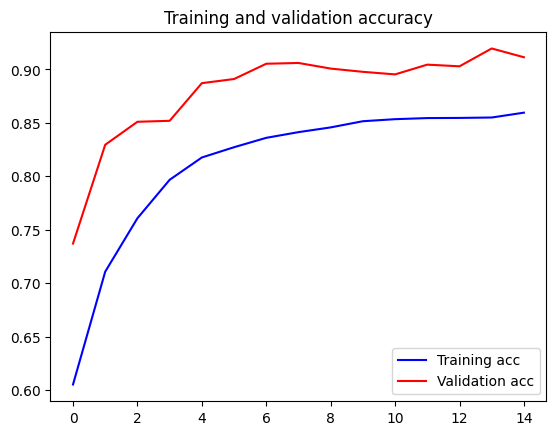

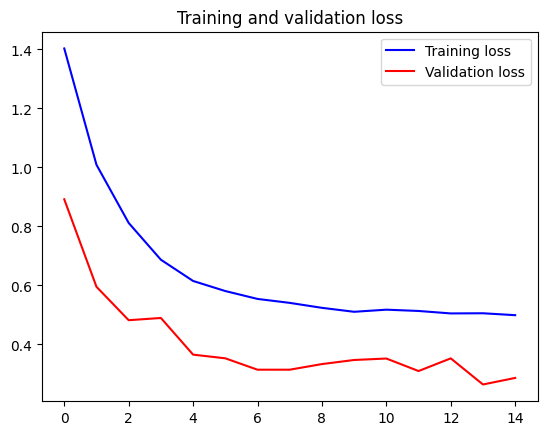

In [ ]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:

scores = model.evaluate(validation_dataset, verbose=0)
print("test Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(train_dataset, verbose=0)
print("train Accuracy: %.2f%%" % (scores[1]*100))

test Accuracy: 91.13%
train Accuracy: 94.20%


543/543 ━━━━━━━━━━━━━━━━━━━━ 124s 229ms/step


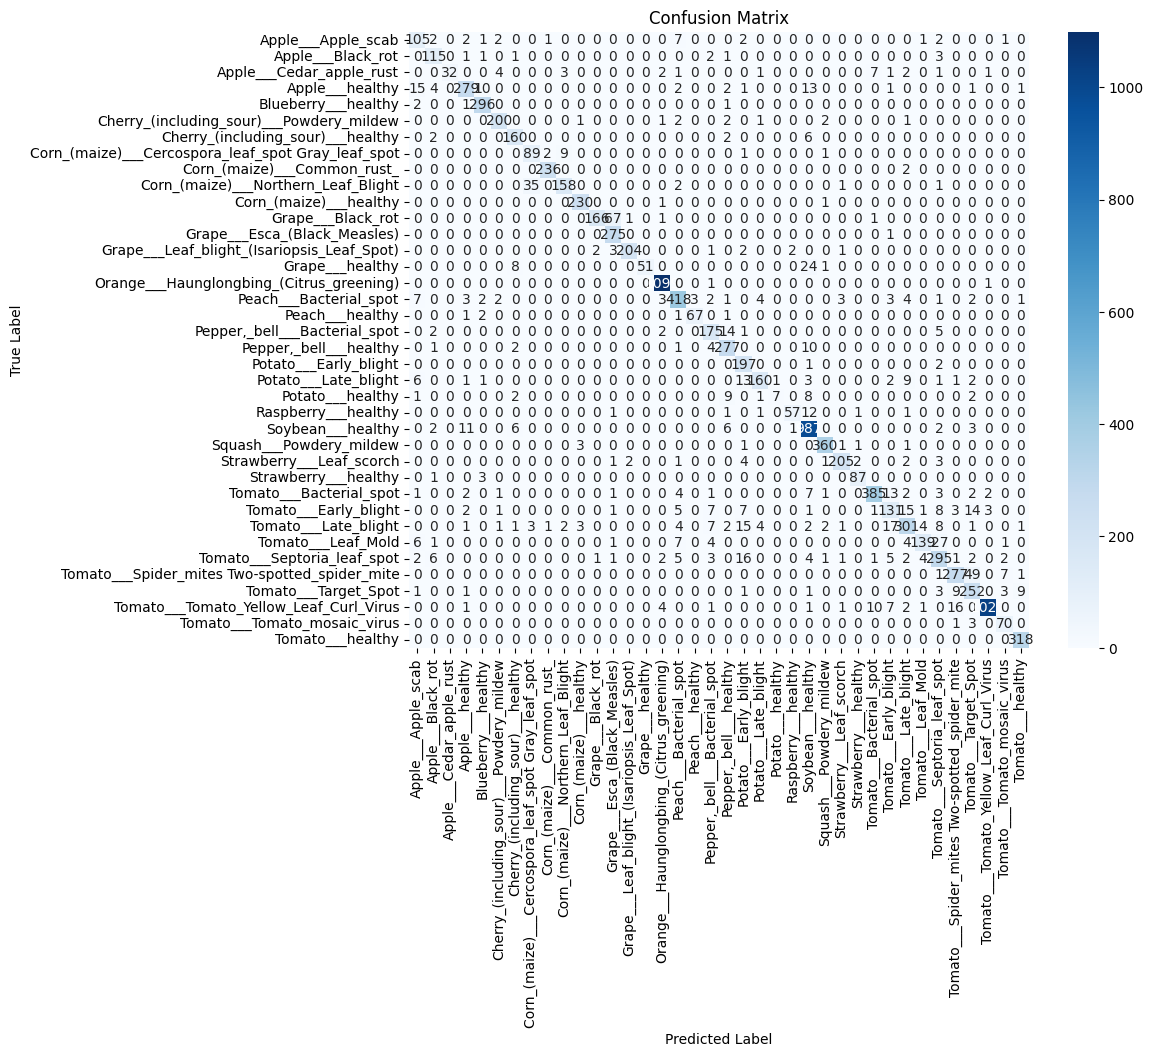

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get class names from the validation dataset
class_names = list(validation_dataset.class_indices.keys())

# Reset the validation dataset
validation_dataset.reset()

# Predict on the entire validation dataset at once
predictions = model.predict(validation_dataset, verbose=1)

# Get true labels from the dataset
true_labels = validation_dataset.classes  # Much faster! No need to loop
predicted_labels = np.argmax(predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate Recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate ROC-AUC Score
# For ROC-AUC, we need the full prediction probabilities and true labels as one-hot
# First check if there are more than two classes
if len(np.unique(true_labels)) > 2:
    # Multi-class AUC
    true_labels_one_hot = np.eye(len(np.unique(true_labels)))[true_labels]
    roc_auc = roc_auc_score(true_labels_one_hot, predictions, multi_class='ovr')
else:
    # Binary AUC
    roc_auc = roc_auc_score(true_labels, predictions[:,1])

# Print scores
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

F1 Score: 0.8955
Precision: 0.9023
Recall: 0.8963
ROC-AUC Score: 0.9959
